# Store Sales Time Series Forecasting adopted from
https://www.kaggle.com/code/sebamosquera/notebook-store-sales-time-series-forecasting#7)-Moving-Average-Plots

In [1]:
from google.colab import files

In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
!pip install kaggle

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c store-sales-time-series-forecasting

 89% 19.0M/21.4M [00:00<00:00, 60.1MB/s]
100% 21.4M/21.4M [00:00<00:00, 66.7MB/s]


In [ ]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from matplotlib import style
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [7]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-bright")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(8, 2),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.5",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# ===========================================================================

In [8]:
train_df = pd.read_csv('train.csv',
                       parse_dates=['date'])
train_df.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [9]:
pd.read_csv('test.csv').sample(3)

,id,date,store_nbr,family,onpromotion
18626,3019514,2017-08-26,31,HARDWARE,0
11753,3012641,2017-08-22,39,BREAD/BAKERY,10
11901,3012789,2017-08-22,42,LINGERIE,0


In [ ]:
#family_labels = [(train_df.family.unique()[i], i) for i in
range(len(train_df.family.unique()))

range(0, 33)

In [ ]:
#train_df['family_labels'] = train_df.family.map(dict(family_labels))

In [ ]:
train_df.sample(4)

,id,date,store_nbr,family,sales,onpromotion
1277449,1277449,2014-12-19,51,LADIESWEAR,4.0,0
2195983,2195983,2016-05-20,24,SCHOOL AND OFFICE SUPPLIES,1.0,0
2492242,2492242,2016-11-02,37,HOME AND KITCHEN II,15.0,2
142420,142420,2013-03-21,54,PERSONAL CARE,96.0,0


# Create store_sales
1.   Set date as an index, to day period
2.   In store_sales set store_nbr and family as an index

In [10]:
store_sales = train_df.copy()
store_sales = store_sales.set_index('date').to_period('D')
store_sales.set_index(['store_nbr', 'family'], append=True)

id     sales  \
date       store_nbr family                                          
2013-01-01 1         AUTOMOTIVE                        0     0.000   
                     BABY CARE                         1     0.000   
                     BEAUTY                            2     0.000   
                     BEVERAGES                         3     0.000   
                     BOOKS                             4     0.000   
...                                                  ...       ...   
2017-08-15 9         POULTRY                     3000883   438.133   
                     PREPARED FOODS              3000884   154.553   
                     PRODUCE                     3000885  2419.729   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000   
                     SEAFOOD                     3000887    16.000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

# Create feature named avarage_sales
Lets create new feature named avarage_sales: grouped by date and estimate mean values of sales per day period, then do a pandas frame (.to_frame())

In [11]:
avarage_sales = store_sales.groupby('date').sales.mean()
avarage_sales.head(4)

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154


In [12]:
avg_sales_df = avarage_sales.to_frame()

# Create time axis
as a arange with length of avarage_sales (index), then add this axis as a new column to avg_sales

In [13]:
time = np.arange(len(avarage_sales.index))

In [14]:
avg_sales_df['time'] = time

In [15]:
avg_sales_df.sample(3)

,sales,time
date,,
2014-04-05,346.621882,458
2016-09-24,483.630971,1359
2015-11-06,376.625021,1037


# Create X and y
X as a time axis and y as a sales values

In [16]:
X = avg_sales_df.loc[:, ['time']]
y = avg_sales_df.loc[:, 'sales']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   time    1684 non-null   int64
dtypes: int64(1)
memory usage: 26.3 KB


In [ ]:
y.info()

<class 'pandas.core.series.Series'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Series name: sales
Non-Null Count  Dtype  
--------------  -----  
1684 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


# Plot ground truth y(X) and linear regresion predictions y_pred(X)

In [17]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

<Axes: xlabel='time', ylabel='sales'>

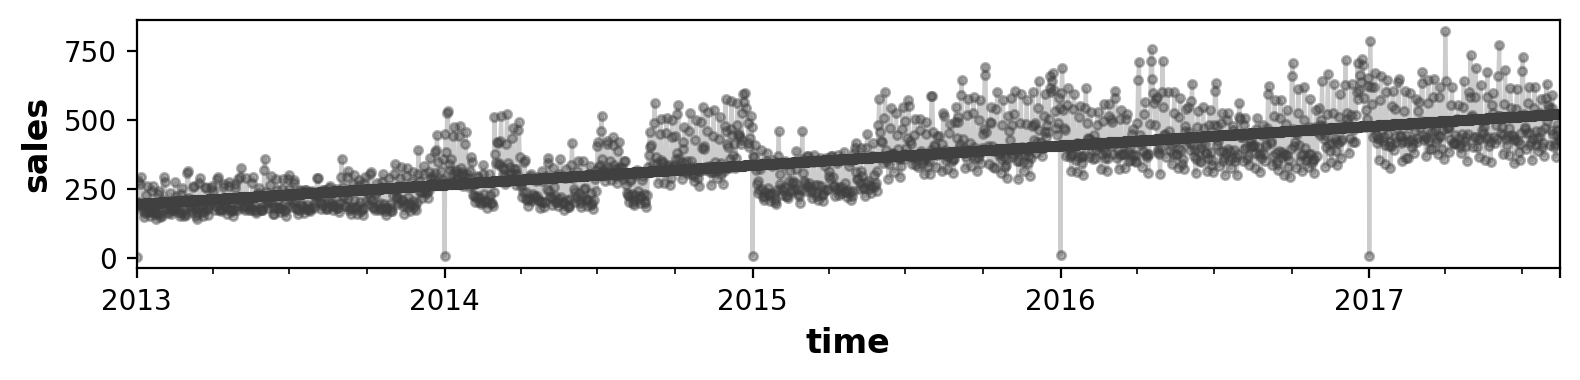

In [18]:
y.plot(**plot_params, alpha=0.4, xlabel='time', ylabel='sales')
y_pred.plot(**plot_params, linewidth=1, xlabel='time', ylabel='sales')

# Time-step features¶
There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end. Time-step features let you model time dependence. A series is time dependent if its values can be predicted from the time they occured. In the Hardcover Sales series, we can predict that sales later in the month are generally higher than sales earlier in the month.
Linear regression with the time dummy produces the model:

target = weight * time + bias

The time dummy then lets us fit curves to time series in a time plot, where Time forms the x-axis.

#Lag features¶
 To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too. Linear regression with a lag feature produces the model:

 target = weight * lag + bias

 So lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.

 If you can see from the lag plot that sales on one day are correlated with sales from the previous day, you know a lag feature will be useful.

 More generally, lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. In Hardcover Sales, we can predict that high sales on one day usually mean high sales the next day.

# Create lag feature
use shift

In [ ]:
avg_sales_df = avarage_sales.to_frame()

# Create a lag feature from the target 'sales'
lag_1 = avg_sales_df['sales'].shift(1)

avg_sales_df['lag_1'] = lag_1  # add to dataframe

X = avg_sales_df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values,
                        # other solution is usage backfilling

y = avg_sales_df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)

# Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

# Plot sales(lag feature)
and sales_predict(lag_feature) obtained by Linear Regresion

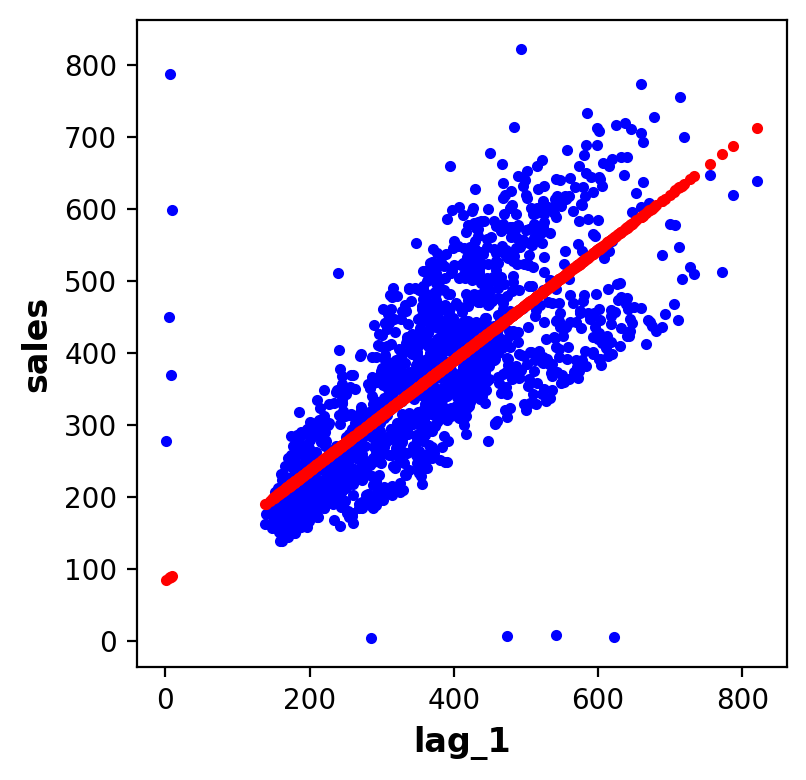

In [ ]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='blue')
ax.plot(X['lag_1'], y_pred, '.', color='red')
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1');

# Plot y(X) and y_predict(X)


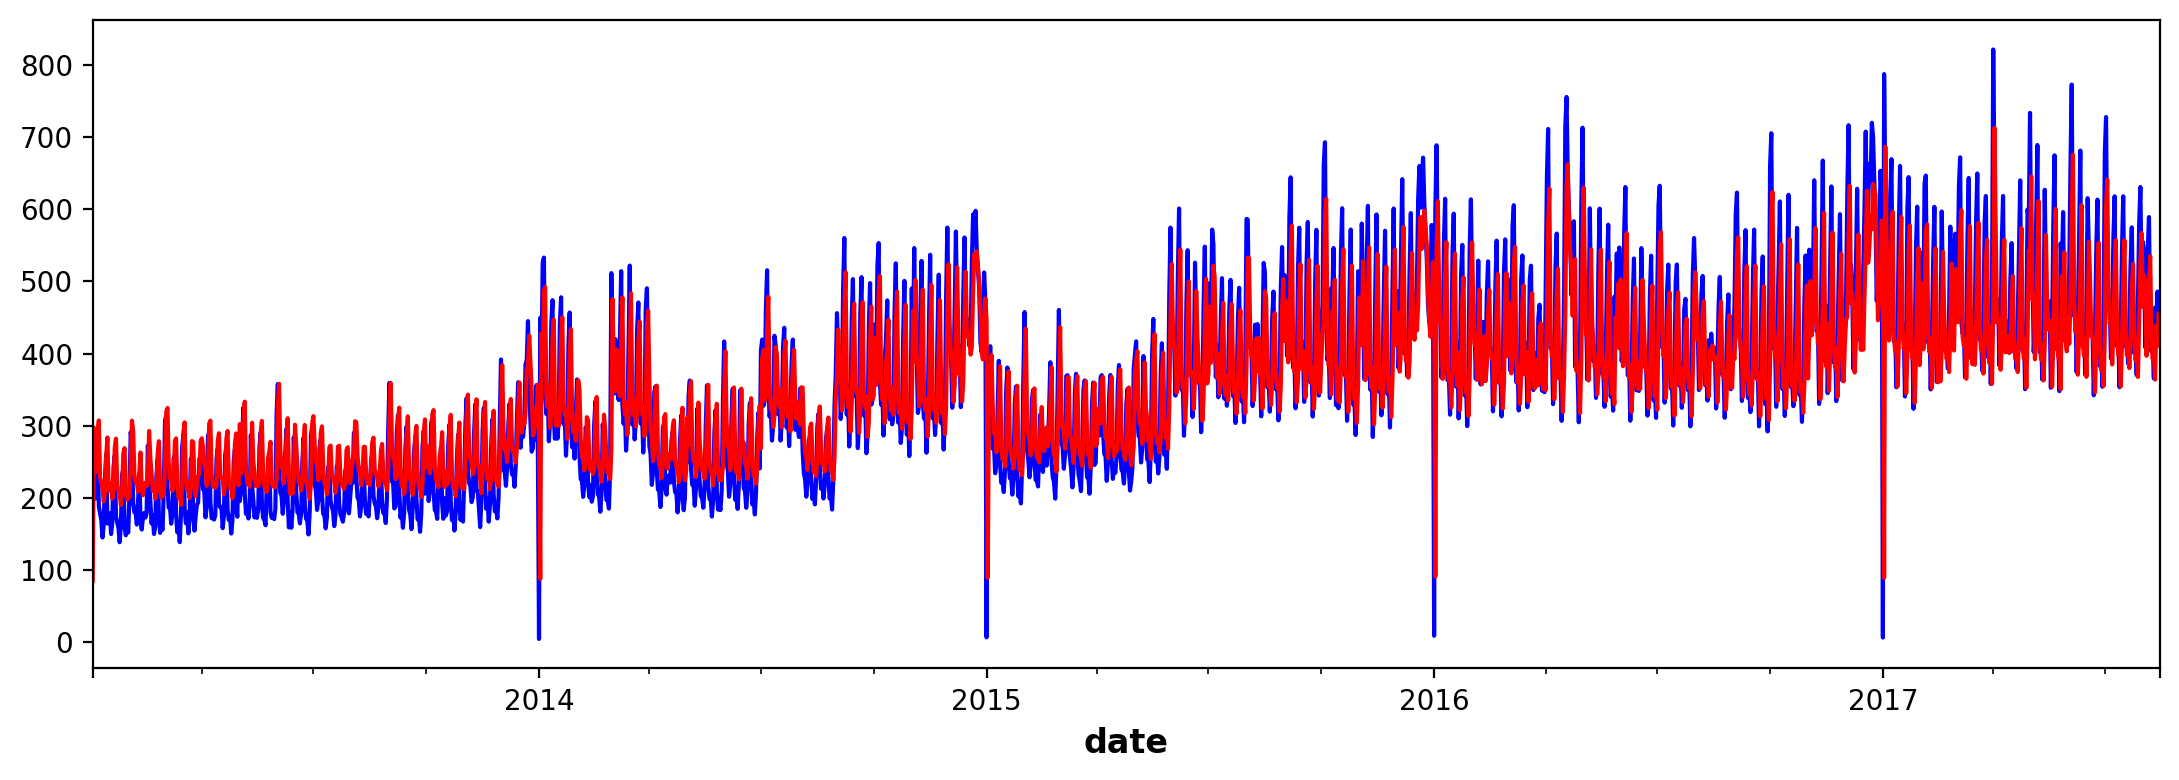

In [ ]:
ax = y.plot(style="-",
                markeredgecolor="0.15",
                markerfacecolor="0.15",color="blue")
ax = y_pred.plot(style="-",
                markeredgecolor="0.15",
                markerfacecolor="0.15",color="red")

# Estimate trend by averaging with window (rolling)
then plot both: average_sales(X) and trend(X)

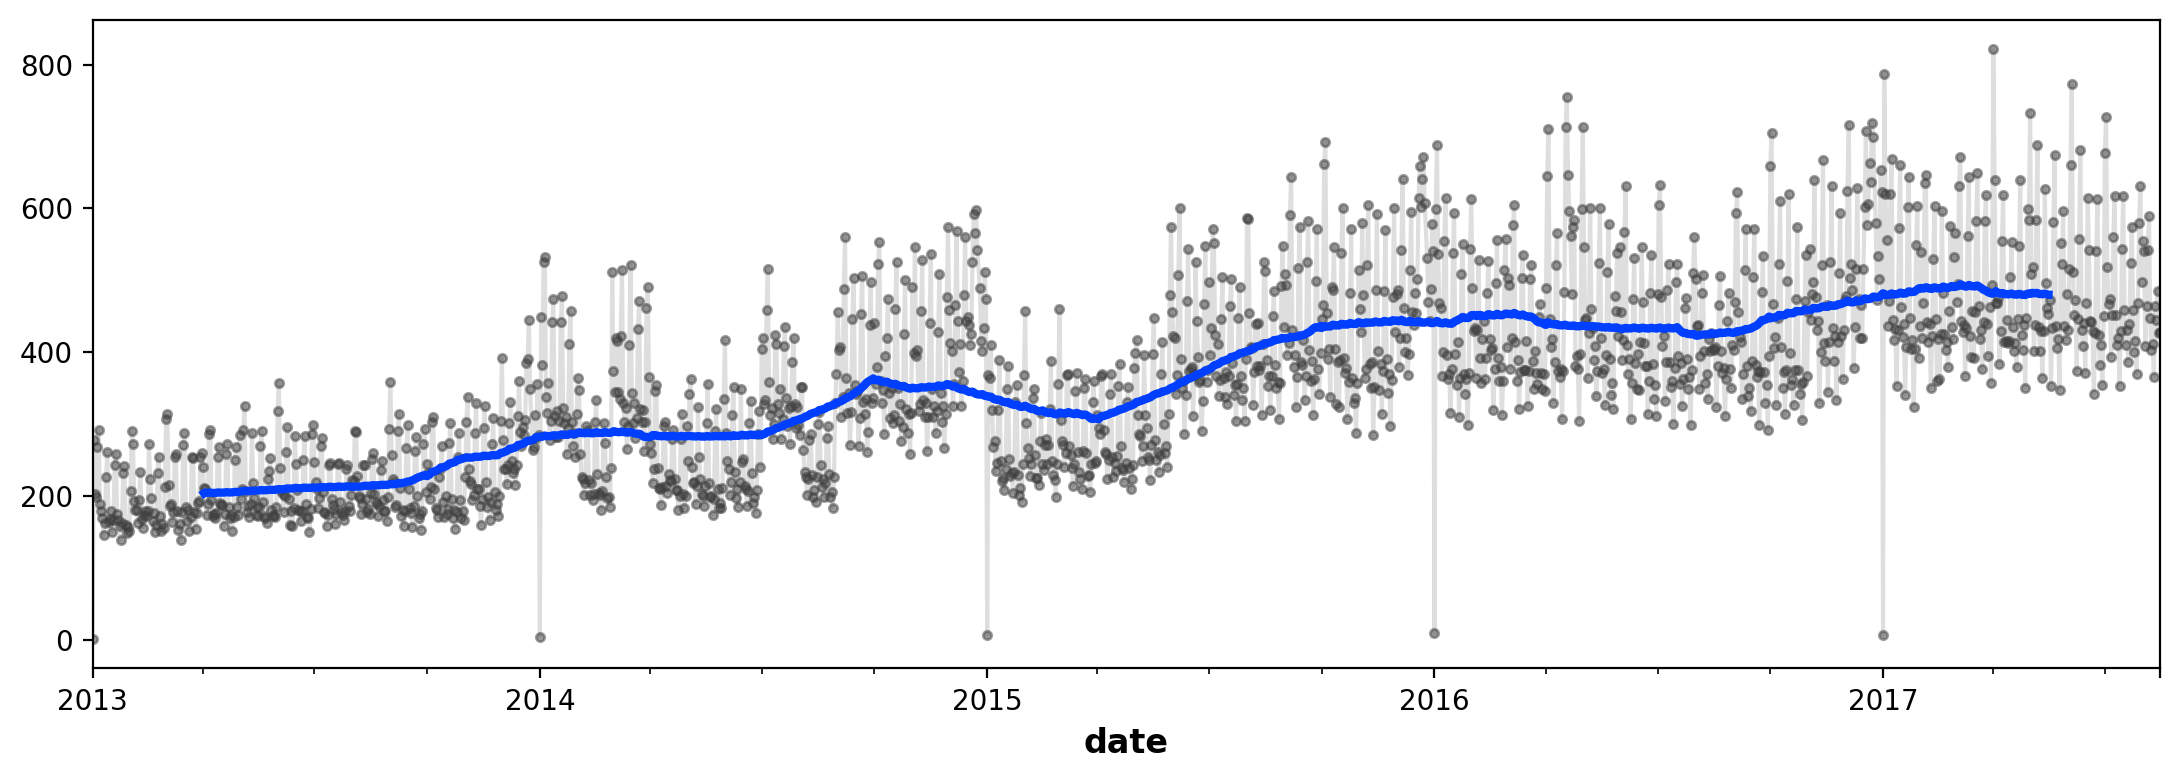

In [ ]:
trend = avarage_sales.rolling(
    window=183,
    center=True,
    min_periods=183,
).mean()

ax = avarage_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# Intermediate conclusion:
The trend apears to be close to cubic.

Previously, features was engineered in Pandas directly. Lets use Deterministic Process from statsmodel. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression.

The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

The best time series models willinclude combination of time-step features and lag features



# Create a Trend Feature - Create DeterministicProcess object (stats)
from statsmodels.tsa.deterministic import DeterministicProcess with order equals 3

In [ ]:
y = avarage_sales.copy()

dp = DeterministicProcess(
        index=avarage_sales.index,
        constant=False,
        order=3,      # the order of trend, here cubic
        drop=True
)

# Plot three characteristics -
To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:
1. ground truth y(X)
2. y_pred (LinearRegresion)(X)
3. forecast (DeterministicProcess) (X)

In [ ]:
# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 360-day forecast.
X_fore = dp.out_of_sample(steps=360)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

X_fore.tail()

,trend,trend_squared,trend_cubed
2018-08-06,2040.0,4161600.0,8.489664e+09
2018-08-07,2041.0,4165681.0,8.502155e+09
2018-08-08,2042.0,4169764.0,8.514658e+09
2018-08-09,2043.0,4173849.0,8.527174e+09
2018-08-10,2044.0,4177936.0,8.539701e+09


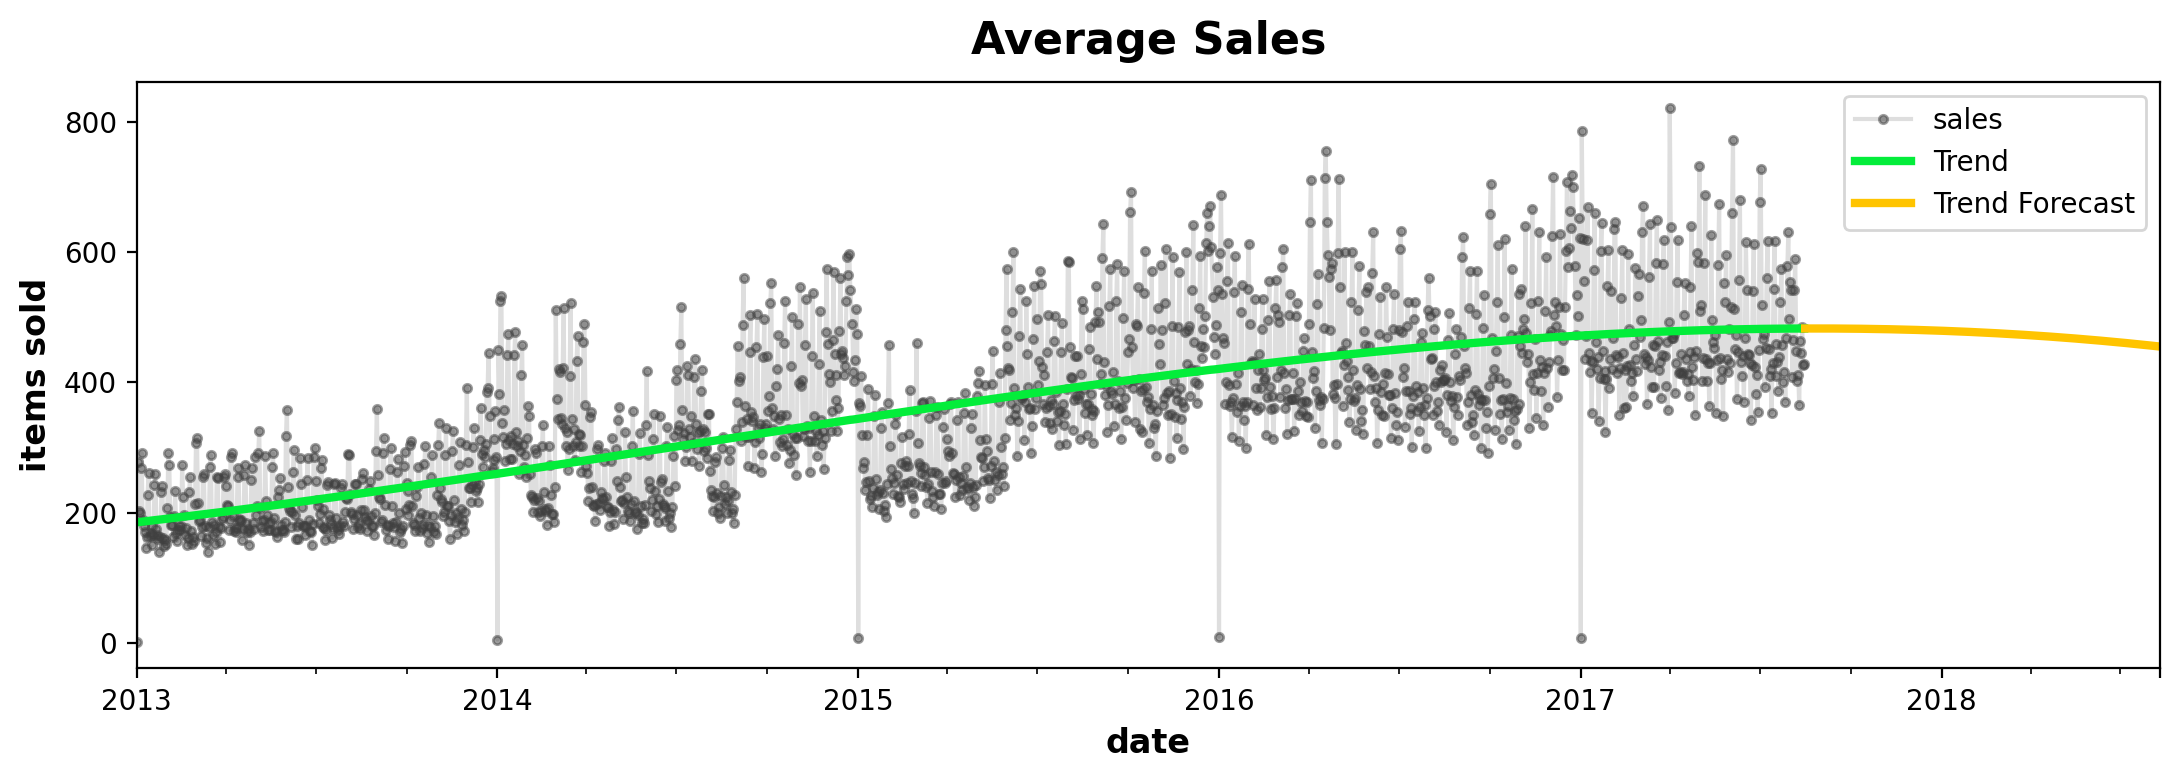

In [ ]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C1')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C4')
ax.legend();

The trend discovered by LinearRegression model is almost identical to the moving average plot, which suggests that a cubic trend was the right decision in this case.

These trend models we learned about turn out to be useful for a number of reasons. Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a “hybrid model” with algorithms unable to learn trends (like XGBoost and random forests).

Seasonality

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar — repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

We will include in our analysis the data from the holidays.csv file, which includes information about holidays and important events, with metadata:

# Load holiday data, set time as index set day period

In [ ]:
holidays_df = pd.read_csv('/content/holidays_events.csv', parse_dates=['date'])
holidays_df.head(4)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False


In [ ]:
holidays_events = holidays_df.copy()
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events.head(4)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False


In [ ]:
store_sales_new = pd.read_csv(
        "train.csv",
        usecols=["store_nbr", "family", "date", "sales"],
        dtype={
            "store_nbr": "category",
            "familiy": "category",
            "sales": "float32",
        },
        parse_dates=['date']
)

store_sales_new['date'] = store_sales_new.date.dt.to_period('D')
store_sales_new = store_sales_new.set_index(['store_nbr',
                                                 'family',
                                                 'date']).sort_index()

store_sales_new = (
    store_sales_new.groupby('date').mean().squeeze().loc['2017']
)

# Plot periodogram
to detect sesonality

In [ ]:
store_sales_new

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]

In [ ]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(0, y_),
            xytext=(1, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodgram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta(days=365) / pd.Timedelta(days=1)
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

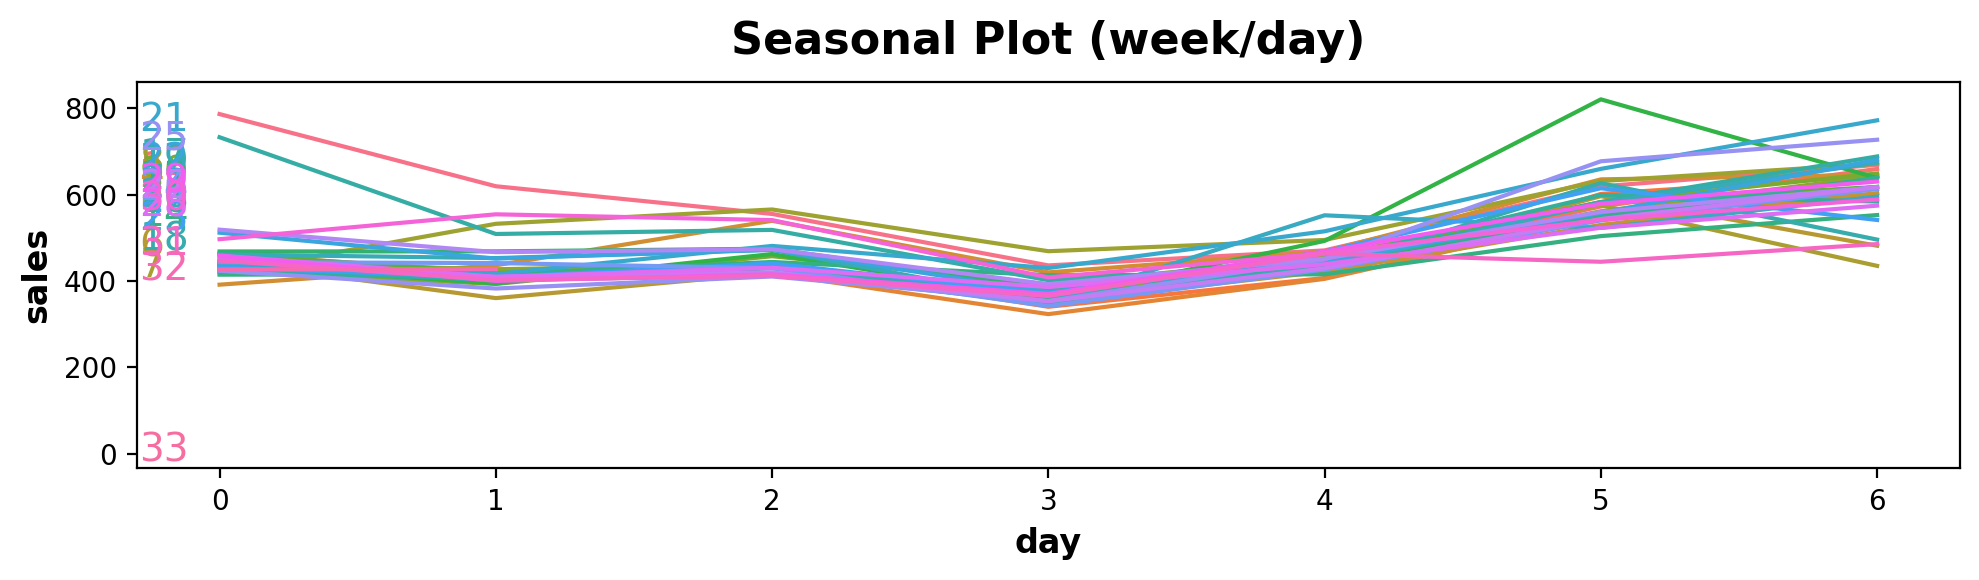

In [ ]:
X = store_sales_new.to_frame()
X["week"] = X.index.week # the seasonal period (period)
X["day"] = X.index.dayofweek # the x-axis (freq)
seasonal_plot(X, y='sales', period='week', freq='day');

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

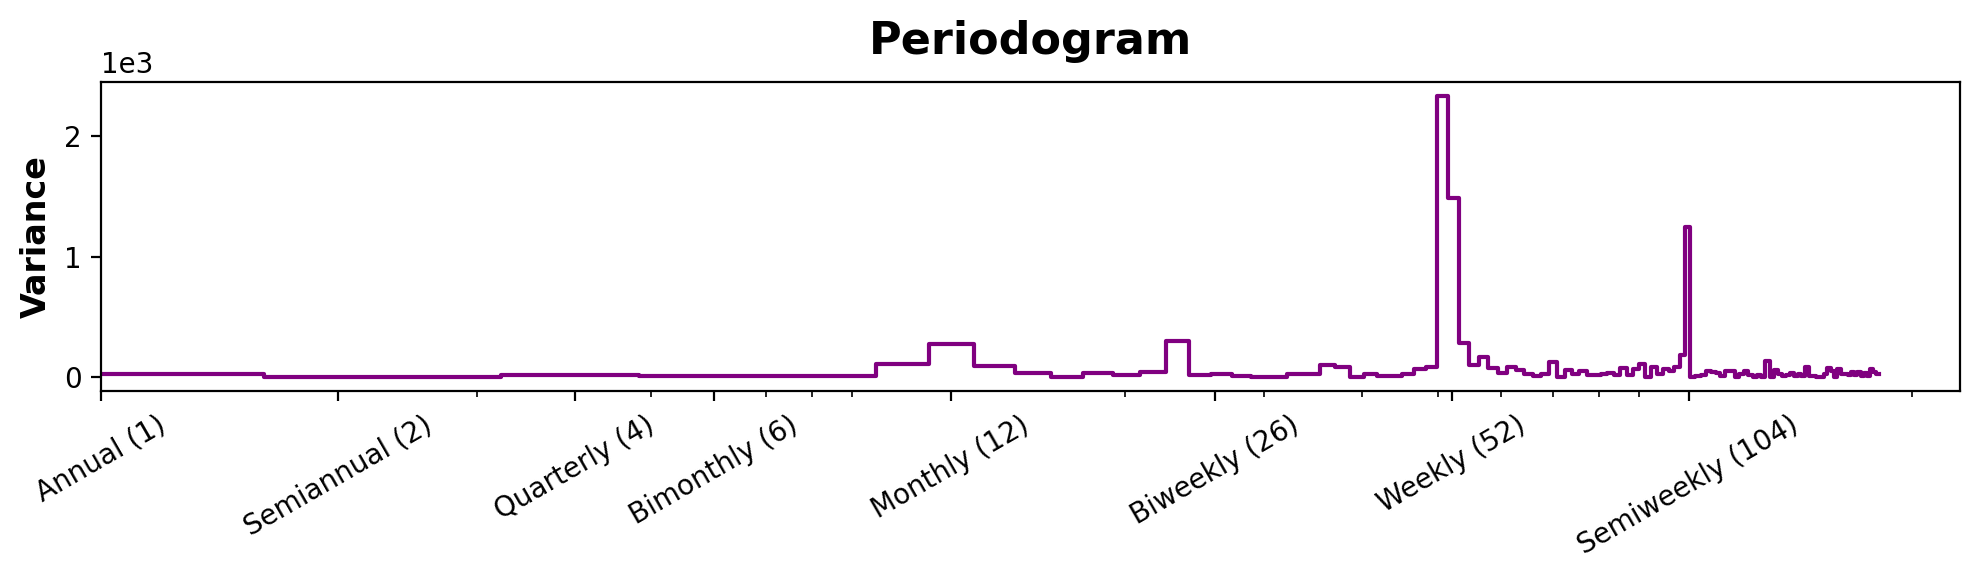

In [ ]:
plot_periodgram(store_sales_new)

# Intermediate conclusion
There is a weekly seasonality

# Create Seasonal Features

We'll create our seasonal features using DeterministicProcess, the same utility we used to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [ ]:
y = store_sales_new.copy()

fourier = CalendarFourier(freq='M', order=4) #  4 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=y.index,
    constant=True,       # dummy feature for bias (y-intercept)
    order=1,             # trend (order 1 means linear)
    # YOUR CODE HERE
    seasonal=True,       # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality (fourier)
    drop=True,           # drop terms to avoid collinearity
)
X = dp.in_sample()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


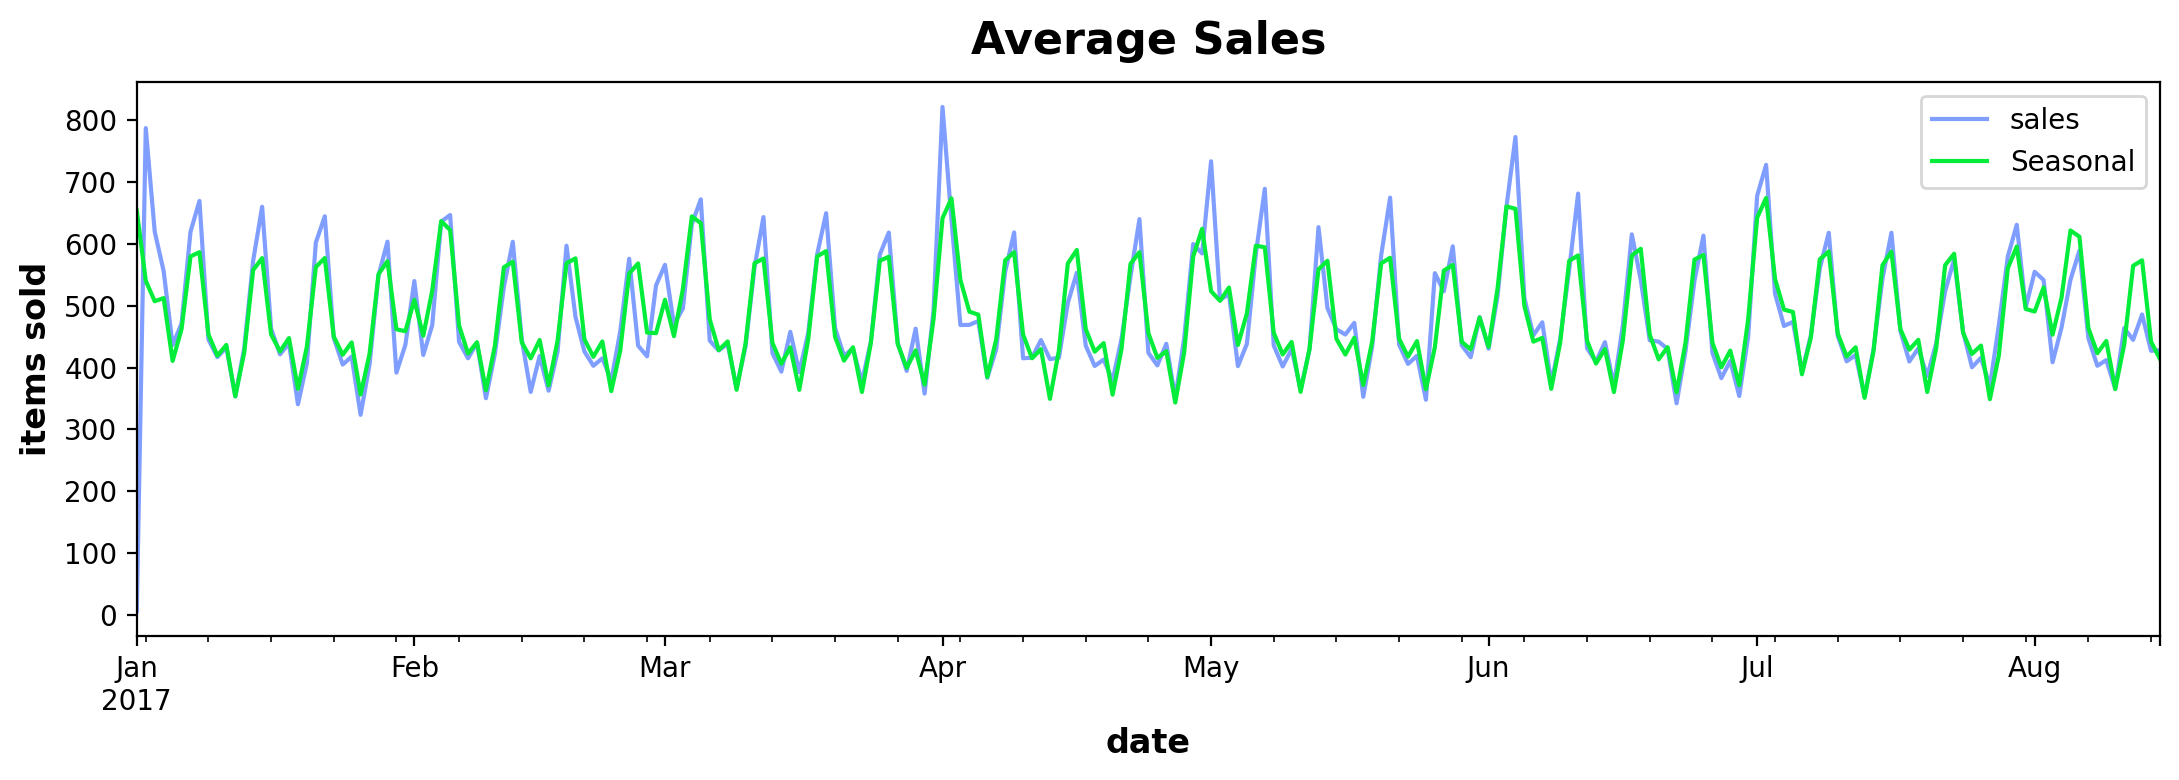

In [ ]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

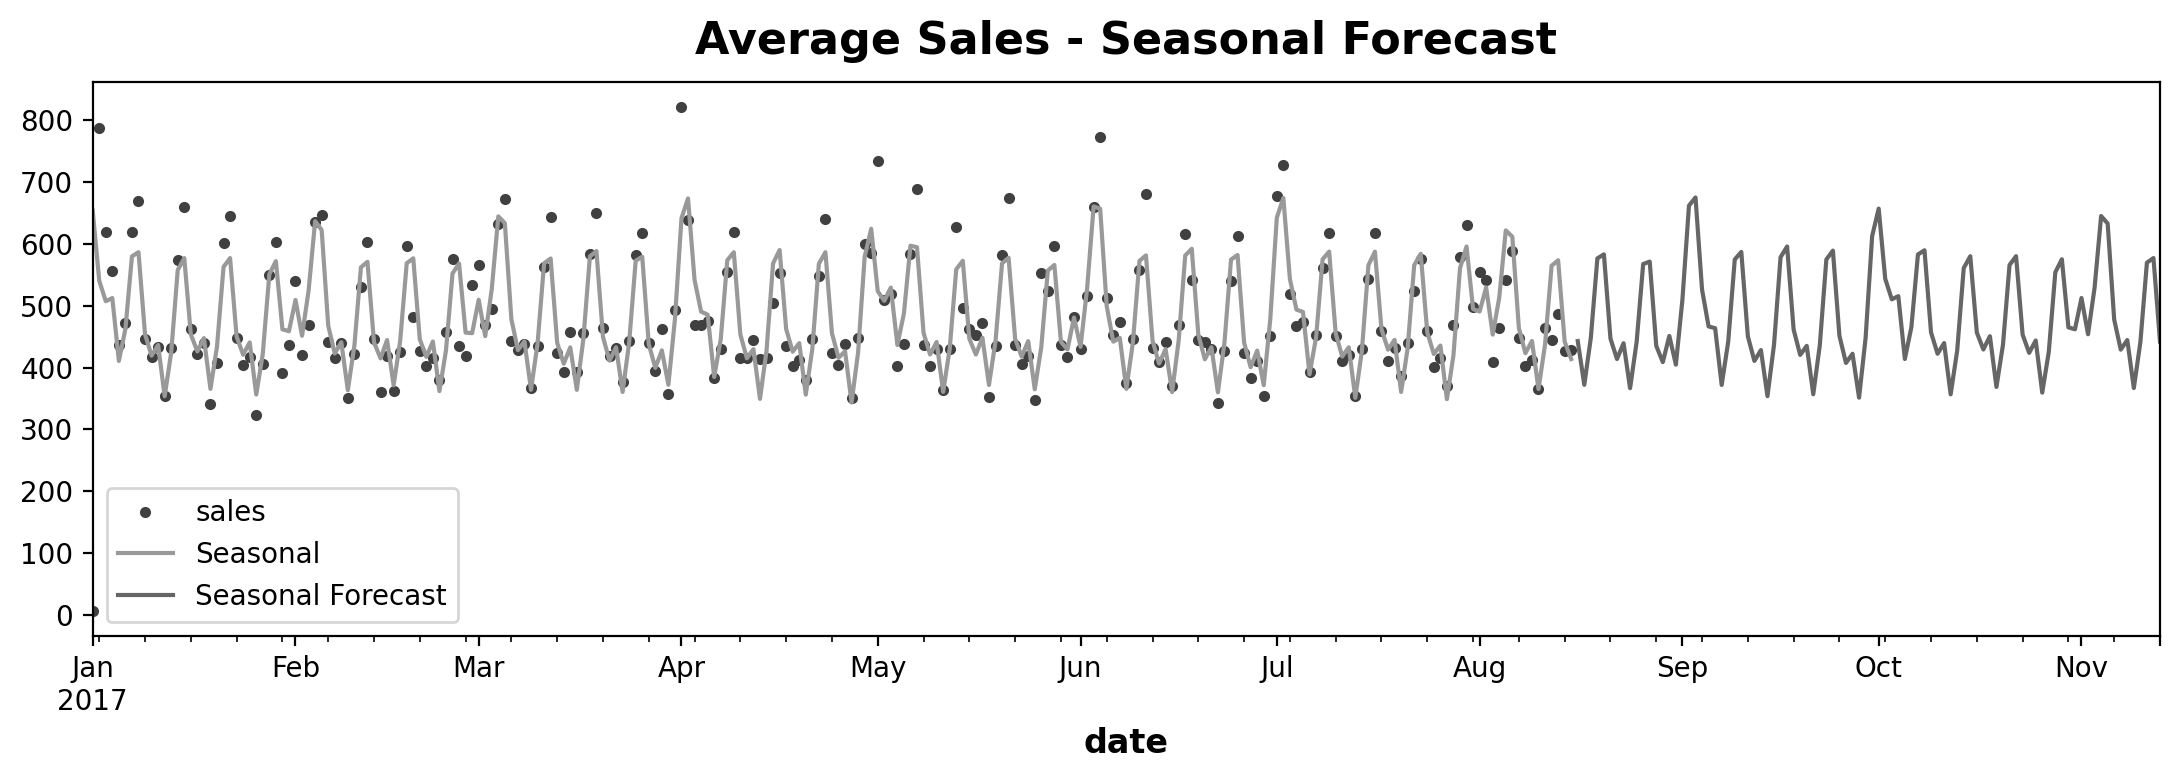

In [ ]:

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Average Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal", color='0.6')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='0.4')
_ = ax.legend()

# Detrending or Deseasonalizing
Removing from a series its trend or seasons is called detrending or deseasonalizing the series.

Look at the periodogram of the deseasonalized series.

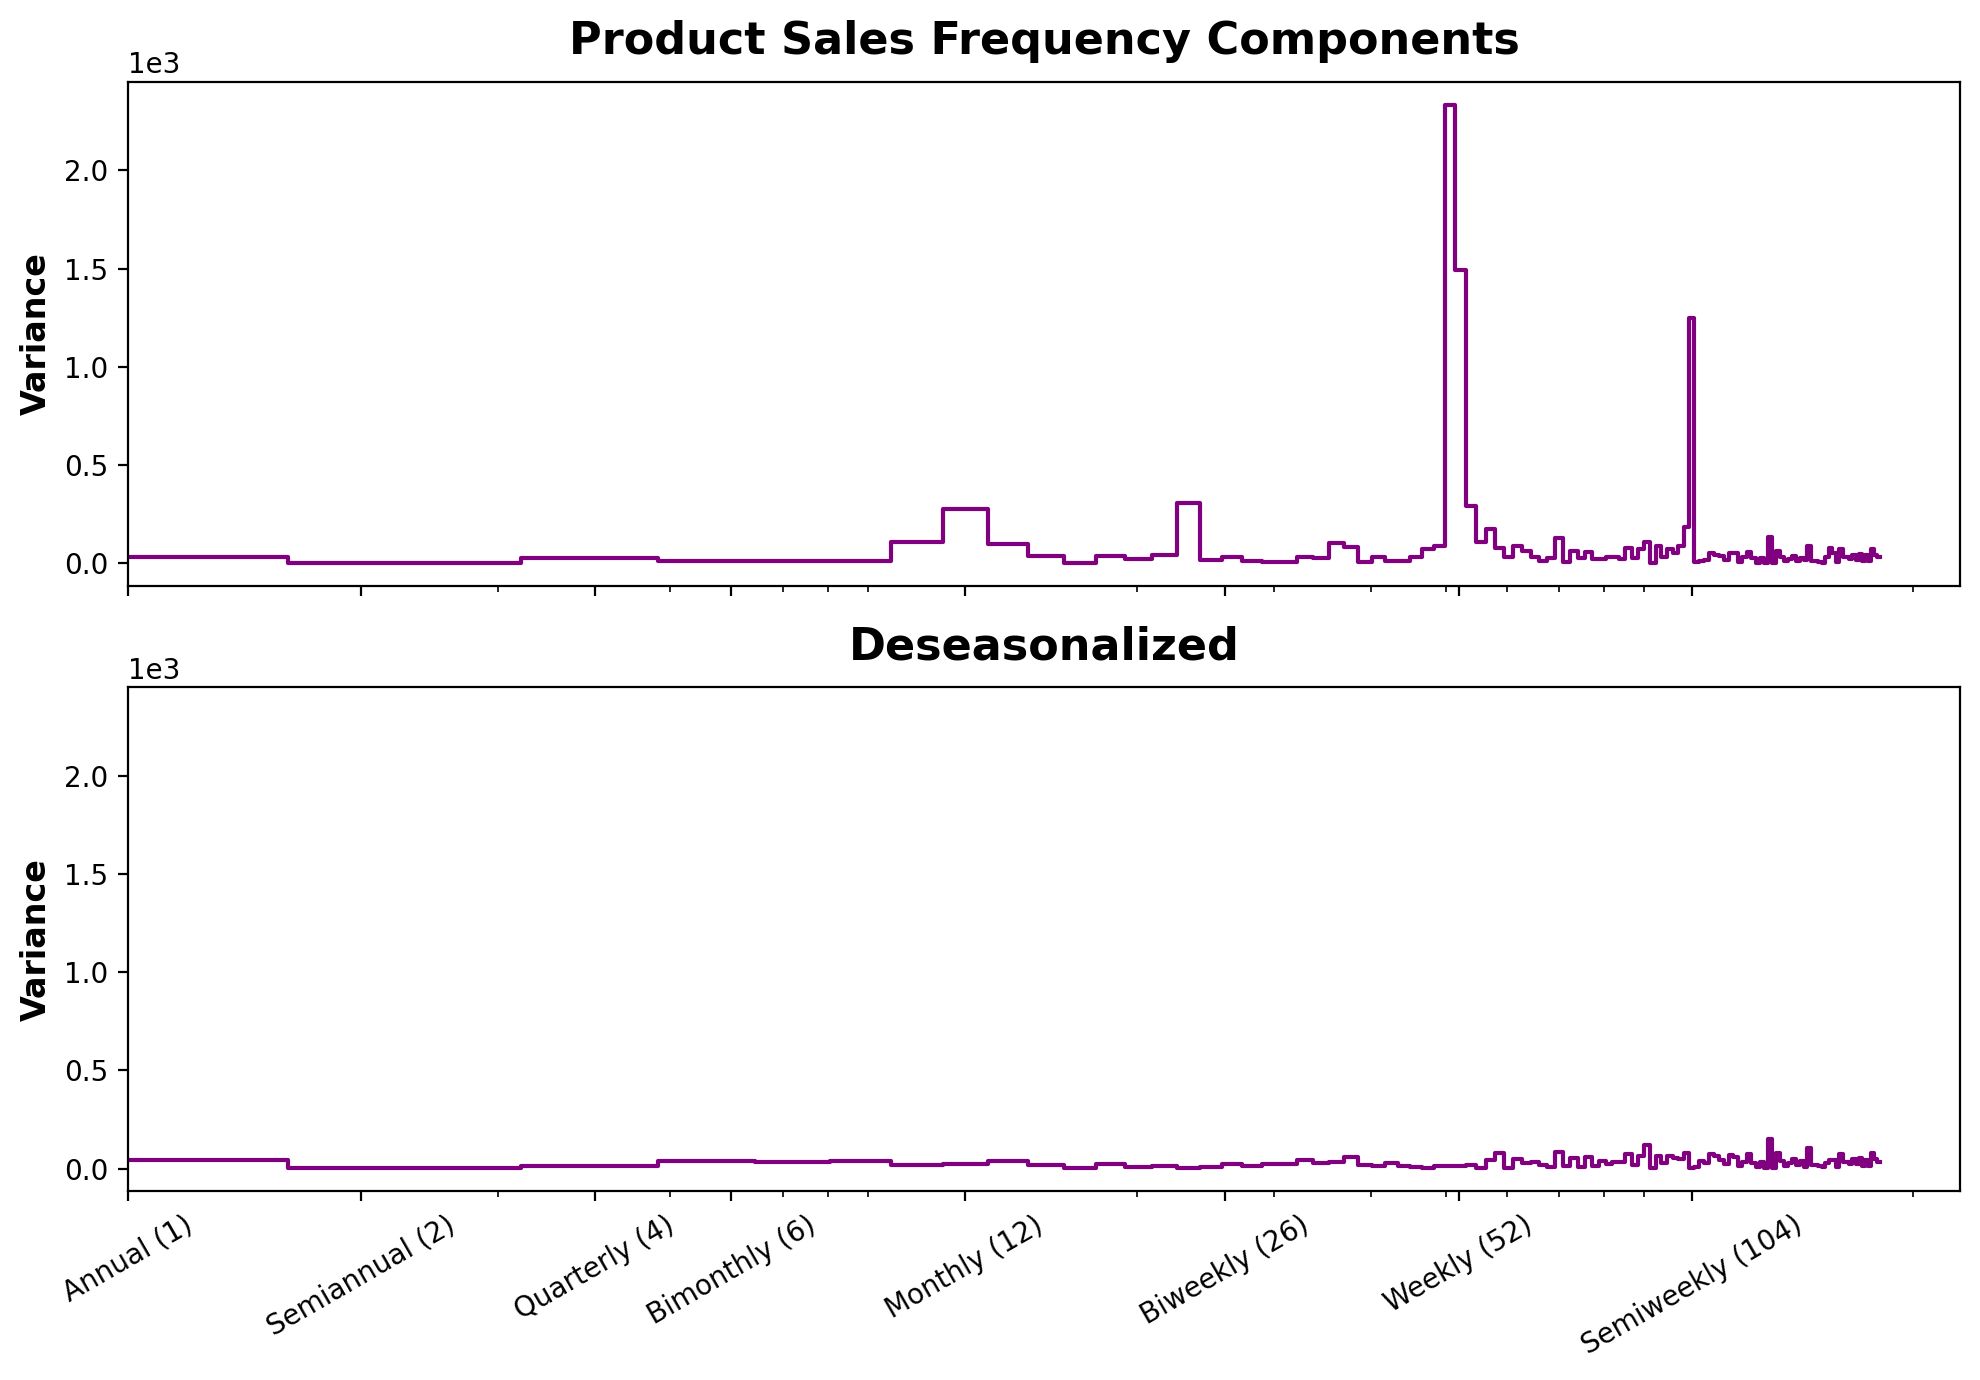

In [ ]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodgram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodgram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

# Holidays Dataframe

In [ ]:
# National and regional holidays in the training set
holidays_events2 = holidays_events.copy()
holidays_events2['description'] = pd.Categorical(holidays_events2['description'])

holidays = (
    holidays_events2
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

<ipython-input-98-0760611d23ab>:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(holidays.index, y_deseason[holidays.index], color='0.4')
<ipython-input-98-0760611d23ab>:2: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot_date(holidays.index, y_deseason[holidays.index], color='0.4')


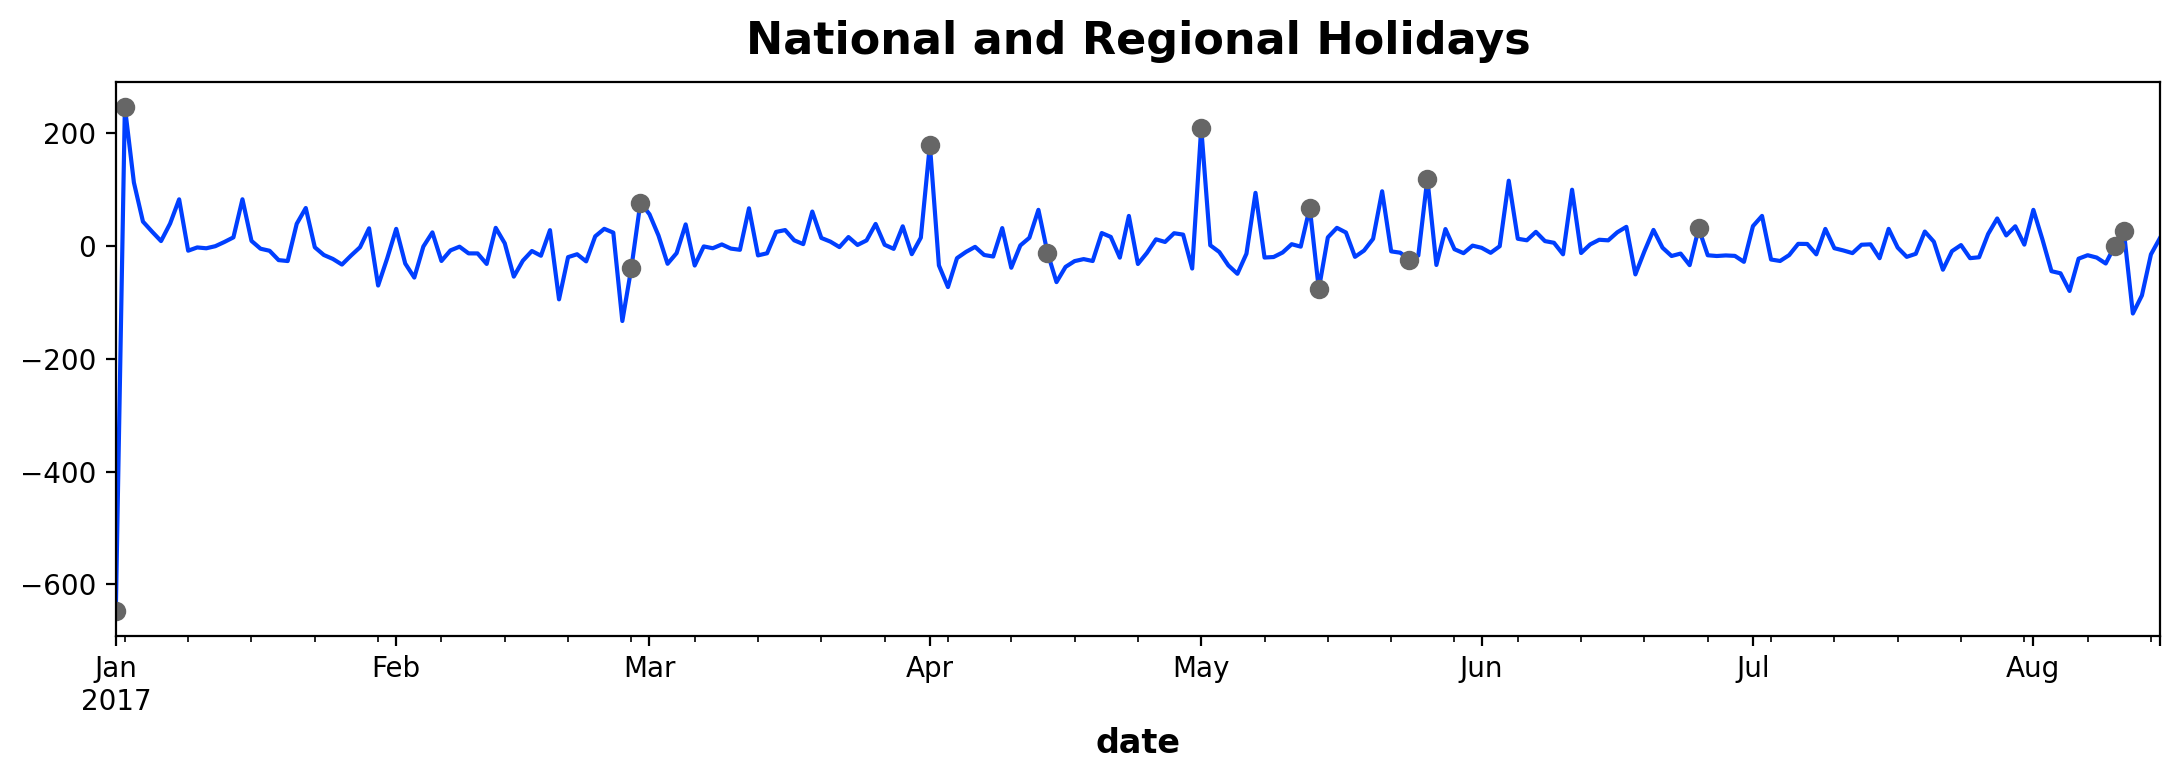

In [ ]:
ax = y_deseason.plot()
plt.plot_date(holidays.index, y_deseason[holidays.index], color='0.4')
ax.set_title('National and Regional Holidays');

# Create holidays feature

In [ ]:
ohe = OneHotEncoder(sparse_output=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

In [ ]:
X2 = X.join(X_holidays, on='date').fillna(0.0)
X2.sample(4)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)",...,Provincializacion de Cotopaxi,Viernes Santo,Dia del Trabajo,Dia de la Madre-1,Dia de la Madre,Batalla de Pichincha,Traslado Batalla de Pichincha,Provincializacion de Imbabura,Primer Grito de Independencia,Traslado Primer Grito de Independencia
date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,1.0,32.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-06,1.0,65.0,1.0,0.0,0.0,0.0,0.0,0.0,0.848644,0.528964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-10,1.0,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.951057,-0.309017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-06-28,1.0,179.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.587785,0.809017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Fit the seasonal model with holiday features added. Do the fitted values seem to have improved?

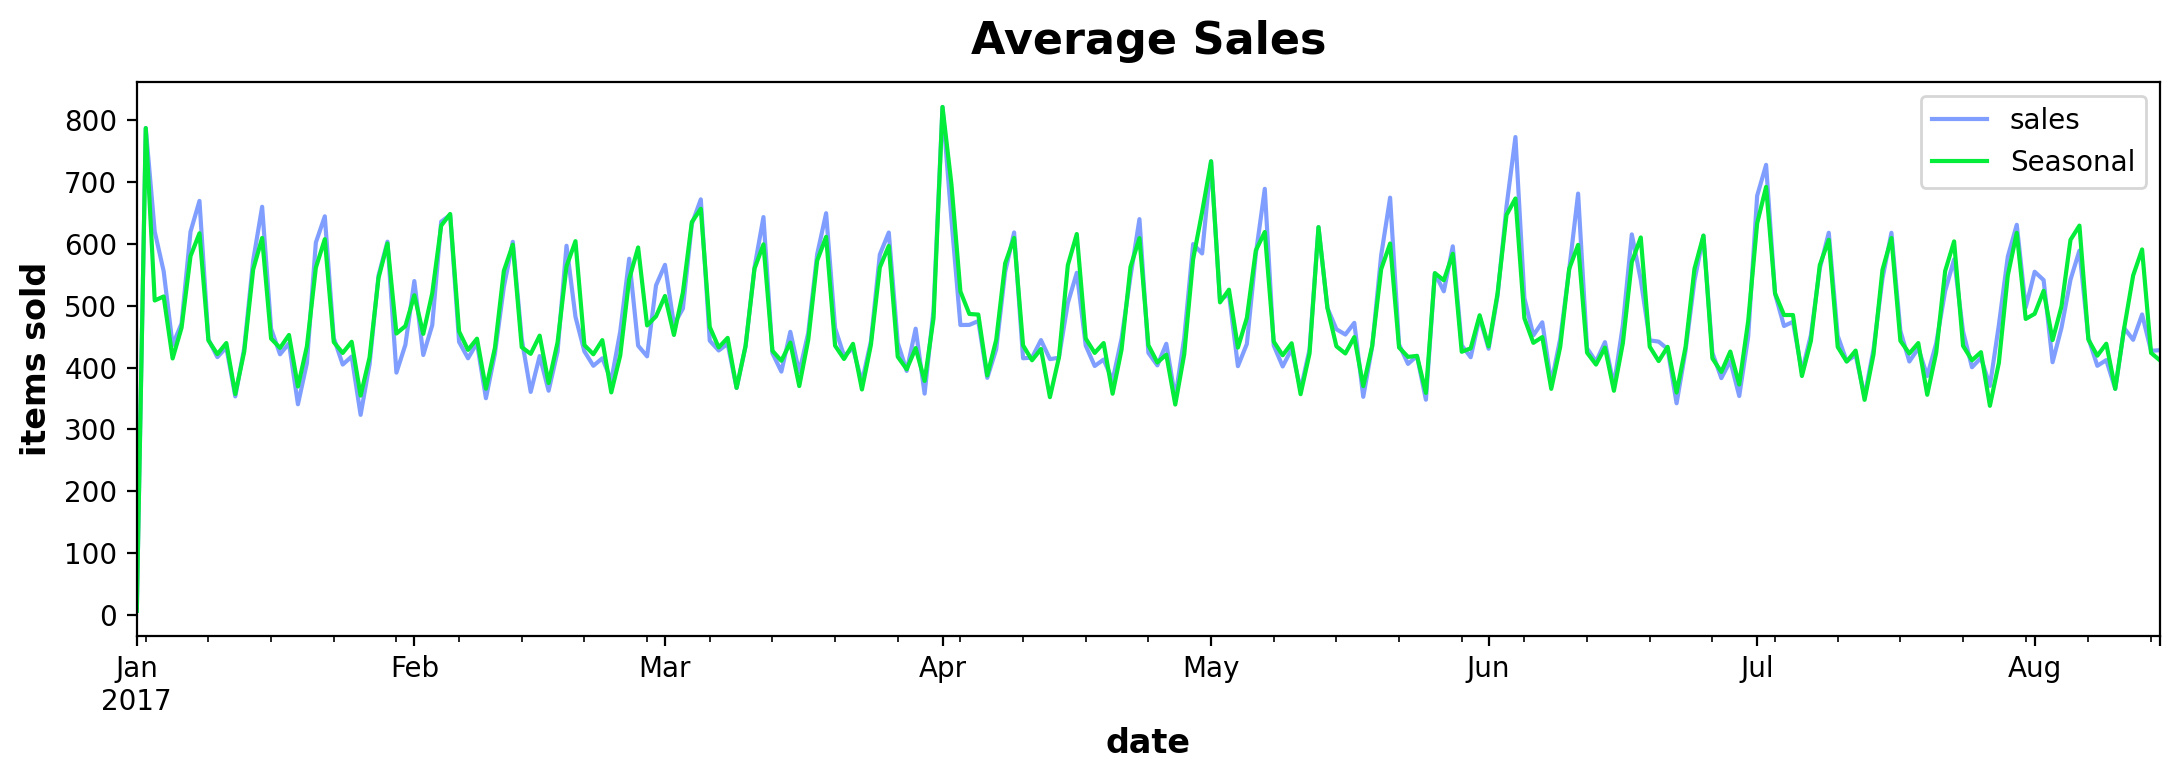

In [ ]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

# Create a seasonal model of the kind we've learned about for the full store sales dataset with all 1800 time series

In [ ]:
y = store_sales_nuevo.unstack(['store_nbr', 'family']).loc['2017']

# Create Training Data
fourier = CalendarFourier(freq="M", order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X,y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


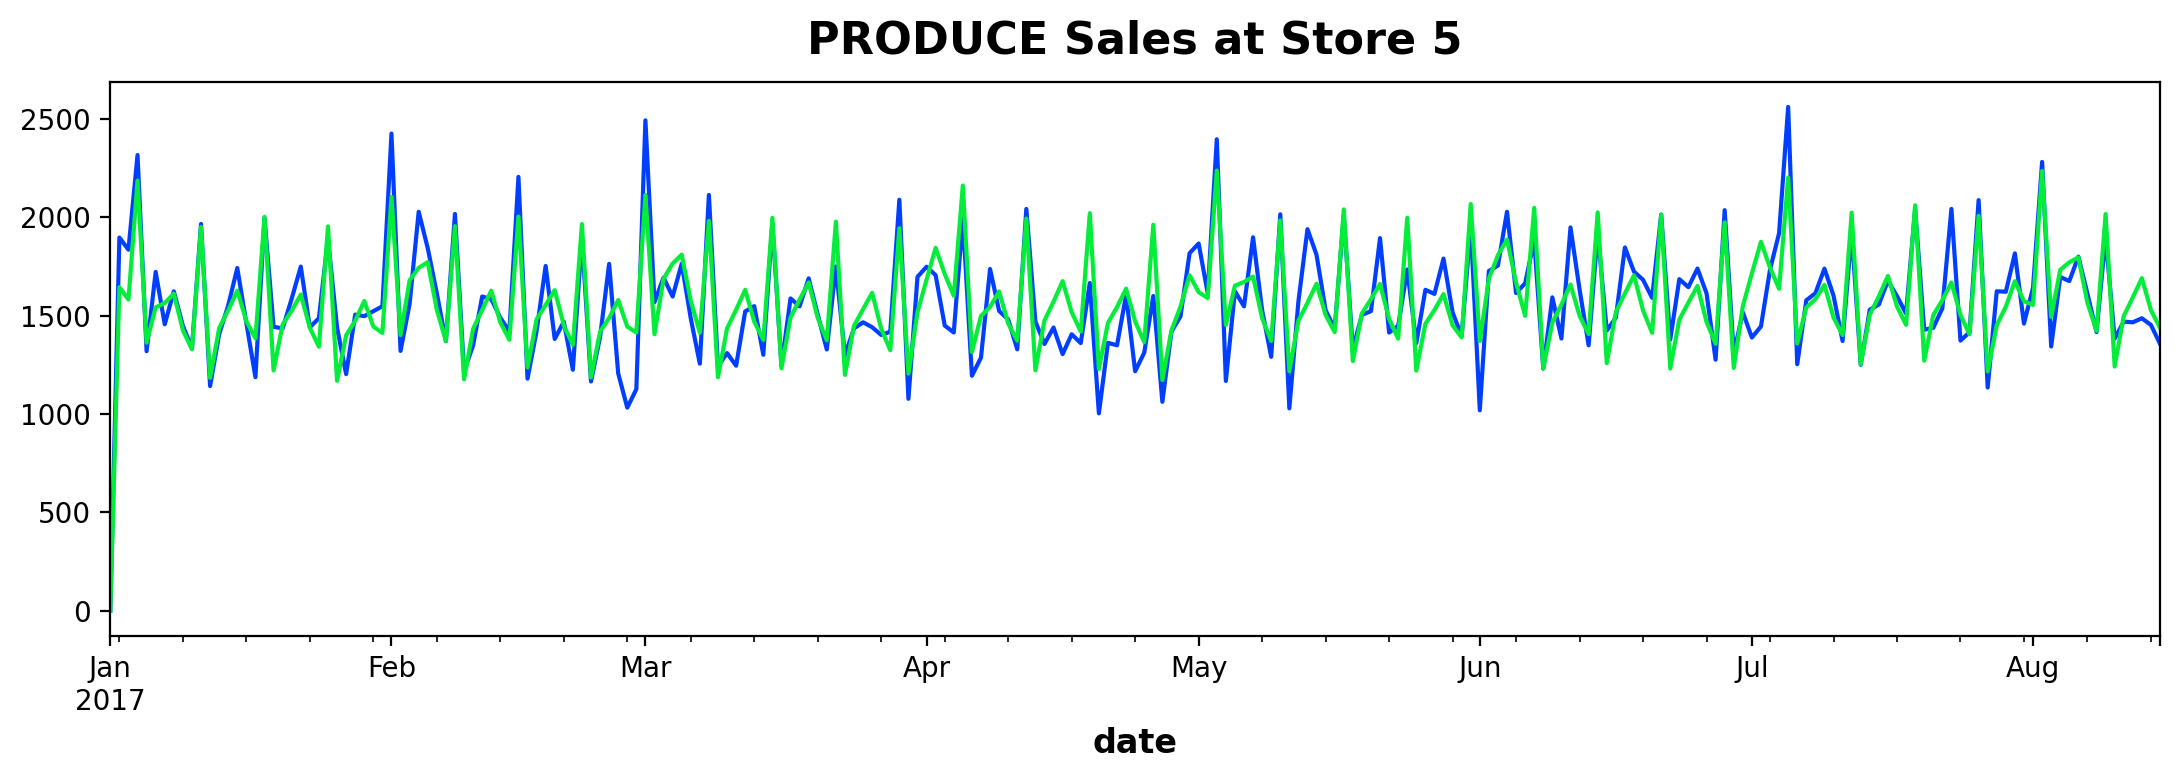

In [ ]:
STORE_NBR = '5'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot()
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

# Load the test data, creates a feature set for the forecast period, and then creates the submission file submission.csv.

In [ ]:
df_test = pd.read_csv('test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

<ipython-input-116-c8b6dae42241>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_test = pd.read_csv('test.csv',
<ipython-input-116-c8b6dae42241>:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_submit = y_submit.stack(['store_nbr', 'family'])
